In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
#---------------------------------------------------------
# View the 2D/3D parameter grid for the BOSZ models
#---------------------------------------------------------
import numpy as np
import scipy as sp
import os
import collections
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as mp3d

from scipy import stats
%matplotlib inline

In [4]:
# Allow load project as module
import sys
sys.path.insert(0, '../')

In [20]:
MH    = para[:,0]
Teff  = para[:,1]
logG  = para[:,2]
CM    = para[:,3]
ALPHA = para[:,4]
uM = np.unique(MH)
uT = np.unique(Teff)
uG = np.unique(logG)
uC = np.unique(CM)
uA = np.unique(ALPHA)

In [26]:
def gridPts(ax,i,j):
    ix = (ALPHA == uA[i]) & (CM==uC[j]) & (Teff<=10000)
    ax.plot(Teff[ix]/1000,logG[ix],MH[ix],'.',markersize=2)
    
def plotGrid(i,j):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')    
    gridPts(ax,i,j)
    ax.set_xlabel('Teff')
    ax.set_ylabel('logG')
    ax.set_zlabel('MH')
    ax.view_init(70,65)
    plt.title(str(i)+':'+str(j))
    plt.draw()

def cuboid(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]     
    X += np.array(o)
    return X

def plotCube(lower,upper,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    sizes= []
    for l,u in zip(lower,upper):
        sizes.append((u[0]-l[0],u[1]-l[1], u[2]-l[2]))
    g = []
    for p,s,c in zip(lower,sizes,colors):
        g.append( cuboid(p,s))
    return mp3d.art3d.Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6), **kwargs)


# 

In [96]:
#--------------------------------------------
# create the block definitions for a 
# reasonable partitining with some overlap
#--------------------------------------------
Blocks = collections.namedtuple('Blocks',['let','name','lower','upper','color'])

def setBlocks():
    #-------------------------------------------------------------------------------
    # M. M31 Giants     :  Teff [3500, 5000]  Logg [0.00, 2.00]  M/H [-2.5, 0.0]
    # W. MW Warm MS     :  Teff [5500, 7500]  Logg [3.25, 5.00]  M/H [-2.0, 0.0]  
    # C. MW Cool MS     :  Teff [3750, 5750]  Logg [3.50, 5.00]  M/H [-2.0, 0.0]
    # B. Blue HB        :  Teff [6750, 9500]  Logg [2.00, 3.25]  M/H [-2.5,-1.5]
    # R. Red HB         :  Teff [5000, 6750]  Logg [2.00, 3.25]  M/H [-1.0, 0.0]
    # G. Dwarf G Giants :  Teff [4000, 5500]  Logg [1.00, 3.50]  M/H [-2.5,-1.0]
    #-------------------------------------------------------------------------------
    let   = ['M','W','C','B','R','G']
    name  = ['M31 Giants','MW Warm MS','MW Cool MS','Blue HB','Red HB', 'Dwarf G Giants']
    color = ['orange','lightgreen','brown','dodgerblue','red','fuchsia']
    lower, upper = [], []
    for R, bnds in c.dRs.items():
        bnds = np.array(bnds)[[1,2,0]].T
        bnds[:,0] /= 1000
        lower.append(list(bnds[0]))
        upper.append(list(bnds[1]))
    
#     lower = [(3.5,0.0,-2.5),(5.5,3.5,-2.0),(3.75,3.5,-2.0),(6.75,2.0,-2.5),(5.00,2.0,-1.0),(4.0,1.0,-2.5)]
#     upper = [(5.0,2.0, 0.0),(7.5,5.0, 0.0),(5.75,5.0, 0.0),(9.50,3.5,-1.5),(6.75,3.5, 0.0),(5.5,3.5,-1.0)]
    # old ranges
    #lower = [(3.5,0.0,-2.5),(5.5,3.5,-2.0),(4.5,4.0,-2.0),(7.0,2.0,-2.5),(5.0,2.0,-1.0),(3.5,0.0,-2.5)]
    #upper = [(5.0,2.0, 0.0),(7.5,5.0, 0.0),(6.0,5.0, 0.0),(9.5,3.0,-1.5),(6.5,3.0, 0.0),(5.5,3.5,-1.0)]
    
    return Blocks(let,name,lower,upper,color)

blk = setBlocks()

print(blk.let)
print(blk.name)
print(blk.lower)
print(blk.upper)
print(blk.color)


['M', 'W', 'C', 'B', 'R', 'G']
['M31 Giants', 'MW Warm MS', 'MW Cool MS', 'Blue HB', 'Red HB', 'Dwarf G Giants']
[[3.5, 0.0, -2.5], [5.5, 3.5, -2.0], [3.75, 3.5, -2.0], [6.75, 2.0, -2.5], [5.5, 2.0, -1.0], [4.0, 1.5, -2.5]]
[[5.0, 1.5, 0.0], [7.5, 5.0, 0.0], [5.5, 5.0, 0.0], [9.5, 3.5, -1.5], [6.75, 3.5, 0.0], [5.5, 3.5, -1.0]]
['orange', 'lightgreen', 'brown', 'dodgerblue', 'red', 'fuchsia']


In [100]:
def showBlocks3D(blk, theta, phi, label=''):
    #---------------------------------------------------------
    # take the block definitions and the viewing angle
        
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')

    pc = plotCube(blk.lower,blk.upper,colors=blk.color,edgecolor="k", lw=0.5, alpha=0.3)
    ax.add_collection3d(pc)    

    ax.set_xlim([10,3])
    ax.set_ylim([5,0])
    ax.set_zlim([-3,0.5])

    ax.set_xlabel('Teff/1000')
    ax.set_ylabel('logG')
    ax.set_zlabel('M/H')
    
    for i in range(len(blk.let)):
        p = blk.lower[i];
        ax.plot(*p,'s',color=blk.color[i],markersize=4)
    
    gridPts(ax,1,1)
        
    ax.legend(blk.name,markerscale=2)
    
    ax.view_init(theta,phi)

    if (label!=''):
        plt.savefig('F-blocks-'+label+'.png');
    
    plt.show()
    
def showBlocks2D12(blk,flag=0):
    #--------------------------------------------
    # plot the 2D parameter grid and the blocks
    # in Teff and log g
    #--------------------------------------------
    ix = (MH ==-2) & (CM==0) & (ALPHA==0)
    fig = plt.figure(figsize=(16,10), facecolor="w")
    ax  = fig.add_subplot(111)
    
    
    ax.set_xlim((12500,3000))
    ax.set_ylim((6,-1))
    ax.set_xlabel('Teff')
    ax.set_ylabel('log g')
    
    for i in range(len(blk.let)):
        lo = blk.lower[i];
        hi = blk.upper[i];
        ax.add_patch(Rectangle((1000*lo[0],lo[1]),(hi[0]-lo[0])*1000,\
            hi[1]-lo[1], facecolor=blk.color[i],alpha=0.45,edgecolor=blk.color[i],lw=2))
    
    ax.legend(blk.name,markerscale=2)
    ax.plot(Teff[ix],logG[ix],'.') 
        
    if (flag>0):
        plt.savefig('F-grid-Teff-logG.png');
    plt.show()

def showBlocks2D23(blk,flag=0):
    #--------------------------------------------
    # plot the 2D parameter grid and the blocks
    # in Teff and log g
    #--------------------------------------------
    ix = (Teff == 6000) & (CM==0) & (ALPHA==0)
    fig = plt.figure(figsize=(16,10), facecolor="w")
    ax  = fig.add_subplot(111)
    
    
    ax.set_xlim((-3,1))
    ax.set_ylim((6,-1))
    ax.set_xlabel('M/H')
    ax.set_ylabel('log g')
    
    for i in range(len(blk.let)):
        lo = blk.lower[i];
        hi = blk.upper[i];
        ax.add_patch(Rectangle((lo[2],lo[1]),(hi[2]-lo[2]),\
            hi[1]-lo[1], facecolor=blk.color[i],alpha=0.45,edgecolor=blk.color[i],lw=2))
    
    ax.legend(blk.name,markerscale=2)
    ax.plot(MH[ix],logG[ix],'.') 
        
    if (flag>0):
        plt.savefig('F-grid-MH-logG.png');
    plt.show()

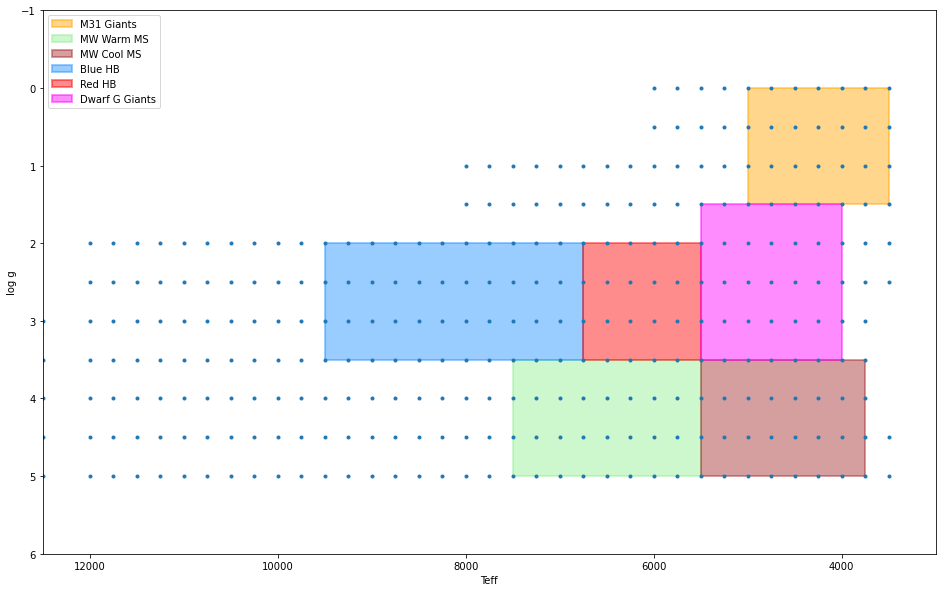

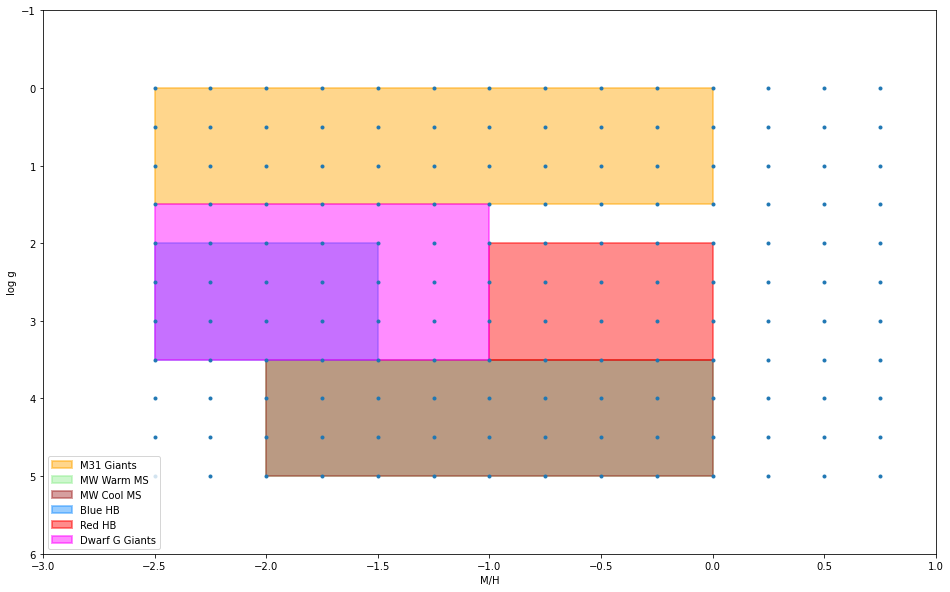

In [101]:
showBlocks2D12(blk,1)
showBlocks2D23(blk,1)

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


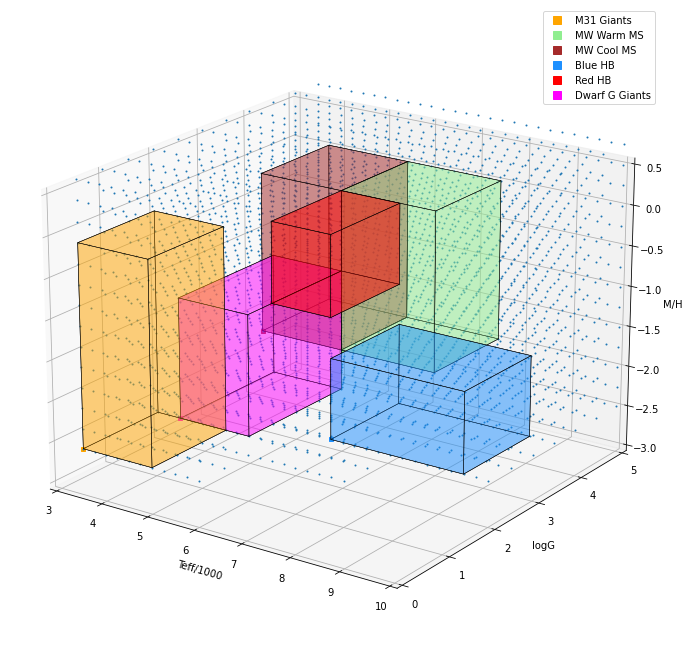

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


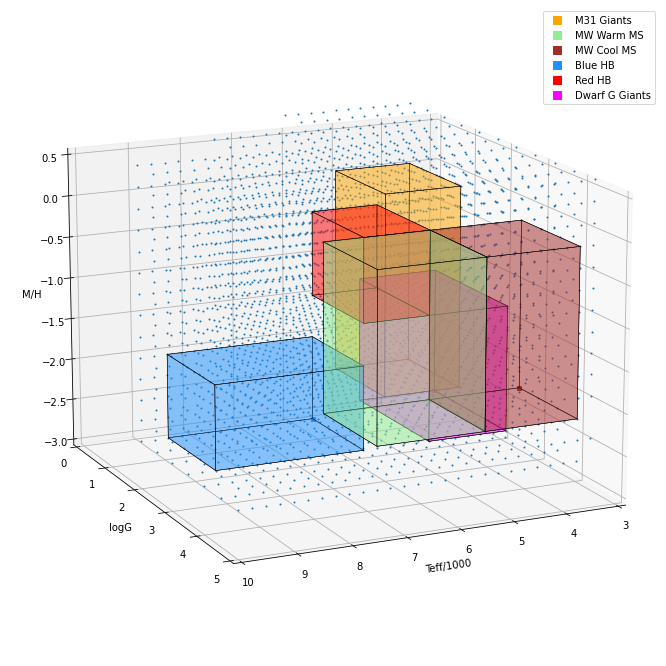

In [102]:
#----------------------------------------
# create a few perspective figures
# will only print if label !=None
#----------------------------------------
showBlocks3D(blk,20,125,'perspective')
showBlocks3D(blk,15,-115,'sideways')

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


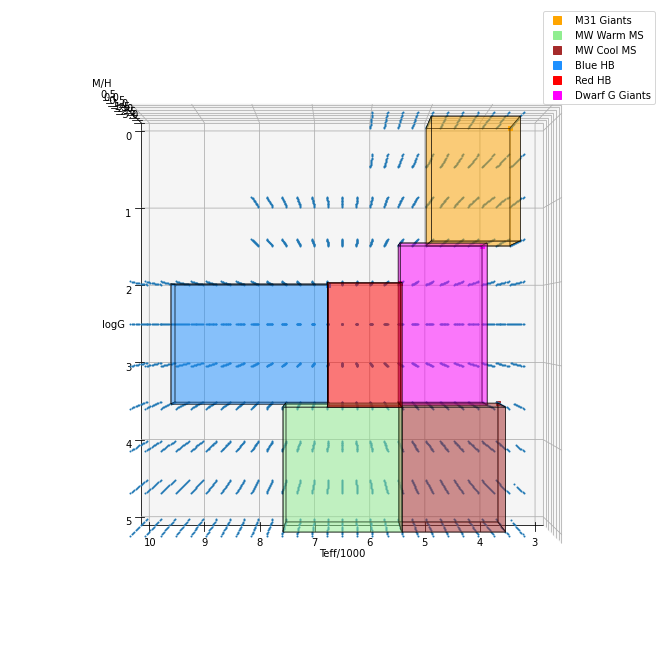

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


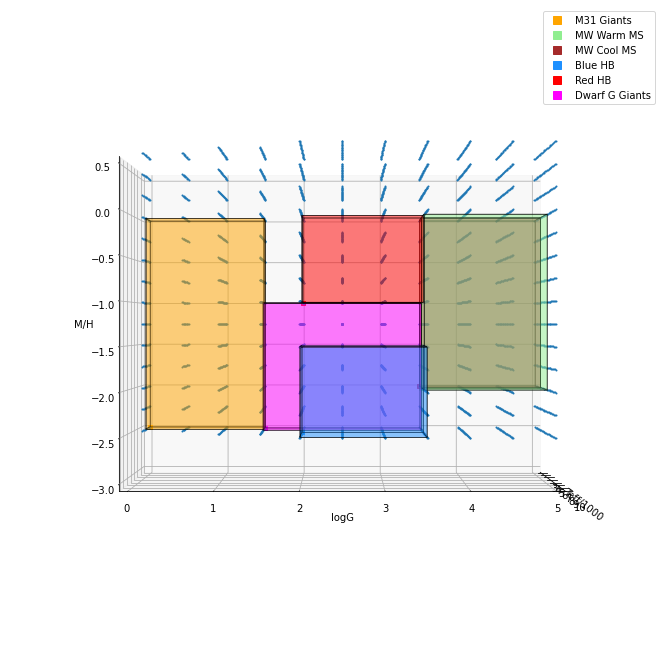

<ipython-input-100-62859022a745>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


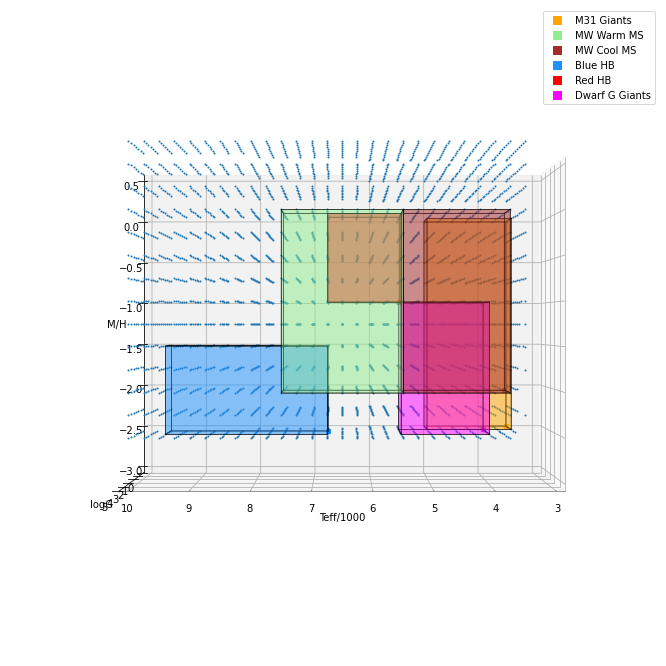

In [103]:
#--------------------------------------
# show the axisparallel projections
#--------------------------------------
showBlocks3D(blk,90,-90,'Teff-logG')
showBlocks3D(blk,0,-180,'logG-M')
showBlocks3D(blk,0,-90,'Teff-M')

In [331]:
from lv.base.box import Box

In [332]:
b = Box()

In [333]:
b.step2_RBF(mkdir=0, boszR=50000)

M
./scripts/build_rbf.sh  grid bosz --config ./configs/import/stellar/bosz/rbf/ --in /scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000 --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_M31G/ --Fe_H -2.5 0.0 --T_eff 3500 5000 --log_g  0.0 1.5 
W
./scripts/build_rbf.sh  grid bosz --config ./configs/import/stellar/bosz/rbf/ --in /scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000 --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_MWW/ --Fe_H -2.0 0.0 --T_eff 5500 7500 --log_g  3.5 5.0 
C
./scripts/build_rbf.sh  grid bosz --config ./configs/import/stellar/bosz/rbf/ --in /scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000 --out /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_MWC/ --Fe_H -2.0 0.0 --T_eff 3750 5500 --log_g  3.5 5.0 
B
./scripts/build_rbf.sh  grid bosz --config ./configs/import/stellar/bosz/rbf/ --in /scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000 --out /scratch/ceph/sw

M
./scripts/prepare.sh sbatch -p elephant --mem 512g model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 1000 --in /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_M31G/rbf --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/M31G/bosz_R5000_RedM_1k_m17_19 --Fe_H -2.5 0.0 --T_eff 3500 5000 --log_g  0.0 1.5 --C_M -0.75 0.5 --O_M -0.25 0.5 --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_i.dat --mag 17 19

In [334]:
b.get_slurm(srun=0, volta=0, sbatch=1)

In [335]:
b.step3_BuildPCA()

M
./scripts/prepare.sh sbatch -p elephant --mem 256g model bosz pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1  --in /scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000 --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/M31G/bosz_R5000_RedM_m19 --Fe_H -2.5 0.0 --T_eff 3500 5000 --log_g  0.0 1.5 --C_M -0.75 0.5 --O_M -0.25 0.5 --norm none --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_i.dat --mag 19  --sample-mode grid
W
./scripts/prepare.sh sbatch -p elephant --mem 256g model bosz pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1  --in /scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000 --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/MWW/bosz_R5000_RedM_m19 --Fe_H -2.0 0.0 --T_eff 5500 7500 --log_g  3.5 5.0 --C_M -0.75 0.5 --O_M -0.25 0.5 --norm 

In [342]:
b.get_slurm(srun=1, volta=0, sbatch=0)

In [343]:
b.get_noise_cmd("B", N=1000)

B
./scripts/prepare.sh srun -p elephant --mem 256g model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 1000 --in /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_BHB/rbf --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/BHB/rbf_R5000_RedM_1k_m19 --Fe_H -2.5 -1.5 --T_eff 6750 9500 --log_g  2.0 3.5 --C_M -0.75 0.5 --O_M -0.25 0.5 --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_i.dat --mag 18 20 --norm none


In [336]:
b.step3_noise(N=1000)

M
./scripts/prepare.sh sbatch -p elephant --mem 256g model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 1000 --in /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_M31G/rbf --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/M31G/rbf_R5000_RedM_1k_m19 --Fe_H -2.5 0.0 --T_eff 3500 5000 --log_g  0.0 1.5 --C_M -0.75 0.5 --O_M -0.25 0.5 --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_i.dat --mag 18 20 --norm none
W
./scripts/prepare.sh sbatch -p elephant --mem 256g model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 1000 --in /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_MWW/rbf --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/MWW/rbf_R5000_RedM_1k_m19 --Fe_H -2.0 0.0 --T_eff 5500 7500 

In [ ]:
./scripts/prepare.sh model bosz pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 100 --sample-count 100 --in /scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000 --out /scratch/ceph/dobos/data/pfsspec/train/pfs_stellar_model/dataset/BHB/bosz_R5000_RedM_1k_m17_19 --Fe_H -2.5 -1.5 --T_eff 6750 9500 --log_g 2.0 3.5 --C_M -0.75 0.5 --O_M -0.25 0.5 --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_i.dat --mag 17 19 --sample-mode grid --threads 8 --top 100

In [92]:
b.step3_noise(N=100000)

M
./scripts/prepare.sh sbatch -p elephant --mem 512g model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 1000 --in /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_M31G/rbf --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/M31G/bosz_R5000_RedM_1k_m17_19 --Fe_H -2.5 0.0 --T_eff 3500 5000 --log_g  0.0 1.5 --C_M -0.75 0.5 --O_M -0.25 0.5 --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_i.dat --mag 17 19
W
./scripts/prepare.sh sbatch -p elephant --mem 512g model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 1000 --in /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_50000_MWW/rbf --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/MWW/bosz_R5000_RedM_1k_m17_19 --Fe_H -2.0 0.0 --T_eff 5500 7500 --lo

./scripts/prepare.py model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 100000 --in /scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_50000_FGK_r/rbf --out /scratch/ceph/dobos/data/pfsspec/train/pfs_stellar_model/dataset/bosz/nowave/train_F_dw_mr_100k --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_z.dat --C_M -0.05 0.05 --O_M -0.05 0.0 --T_eff 6000 7500 --log_g 4.0 4.4 --mag 17 19

In [75]:
PATH="/scratch/ceph/dobos/data/pfsspec/train/pfs_stellar_model/dataset/BHB/bosz_R5000_RedM_1k_m17_19"

In [86]:
PATH ="/scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/BHB/"

In [87]:
os.path.isdir(PATH)

False

In [94]:
b.convert("B", N=1000, step=20)

#204 R=929.31
(100, 4096) (100, 204) (100, 4096) (100, 5)


In [26]:
b.step4_downSample(N=1000, step=20)

#204 R=929.31
(1000, 4096) (1000, 204) (1000, 4096) (1000, 5)
#204 R=929.31
(1000, 4096) (1000, 204) (1000, 4096) (1000, 5)
#204 R=929.31
(1000, 4096) (1000, 204) (1000, 4096) (1000, 5)
#204 R=929.31
(1000, 4096) (1000, 204) (1000, 4096) (1000, 5)
#204 R=929.31
(1000, 4096) (1000, 204) (1000, 4096) (1000, 5)
#204 R=929.31
(1000, 4096) (1000, 204) (1000, 4096) (1000, 5)


In [39]:
b.step4_downSample(N=10000, step=20)

#204 R=929.31
(10000, 4096) (10000, 204) (10000, 4096) (10000, 5)
#204 R=929.31
(10000, 4096) (10000, 204) (10000, 4096) (10000, 5)
#204 R=929.31
(10000, 4096) (10000, 204) (10000, 4096) (10000, 5)
#204 R=929.31
(10000, 4096) (10000, 204) (10000, 4096) (10000, 5)
#204 R=929.31
(10000, 4096) (10000, 204) (10000, 4096) (10000, 5)
#204 R=929.31
(10000, 4096) (10000, 204) (10000, 4096) (10000, 5)


In [40]:
b.step5_PCA(W="RML", N=10000, top=100)

# M31G flux: (10000, 204), wave RML: (204,) 
# MWW flux: (10000, 204), wave RML: (204,) 
# MWC flux: (10000, 204), wave RML: (204,) 
# BHB flux: (10000, 204), wave RML: (204,) 
# RHB flux: (10000, 204), wave RML: (204,) 
# DGG flux: (10000, 204), wave RML: (204,) 
/scratch/ceph/swei20/data/dnn/PC/logPC/RML_R1000.h5


# testing

In [250]:
R="B"
wave, flux, error, para, snr = b.load_dataset(R, grid=1)

In [251]:
norm_flux = np.divide(flux, flux.mean(1)[:,None])

In [278]:
norm_flux.mean()

1.0

In [277]:
norm_flux.min(), norm_flux.max()

(0.4396199908310456, 1.3970875074703983)

In [252]:
waveL, fluxL = b.resample(wave, norm_flux, step=20)  

#204 R=929.31


In [253]:
logfluxL = np.log(fluxL)

In [281]:
logfluxL.min(), logfluxL.max()

(-0.6384615604974136, 0.3321890533832597)

In [254]:
_,s,v=np.linalg.svd(logfluxL)

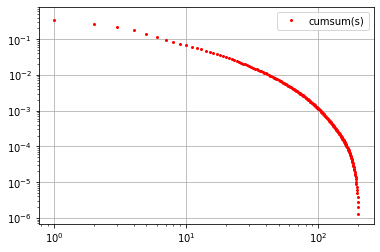

In [255]:
plt.figure(facecolor="w")
ss = 1-np.cumsum(s)/np.sum(s)
plt.plot(ss[:-2],'ro', markersize=2,label="cumsum(s)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid()


In [256]:
def plot_V(wave, nv, top=5, step=0.3, ax=None):
    size = top // 5
    if ax is None: ax = plt.subplots(1, figsize=(16,5 * size),facecolor="w")[1]
    for i in range(min(len(nv),top)):
        ax.plot(wave, nv[i] + step*(i+1))
    get_wave_axis(wave, ax=ax)
def get_wave_axis(wave, ax=None, xgrid=True):
    ax.set_xlim(wave[0]-1, wave[-1]+2)
    ax.set_xticks(np.arange(int(wave[0]), np.ceil(wave[-1]), 200))
    ax.xaxis.grid(xgrid)

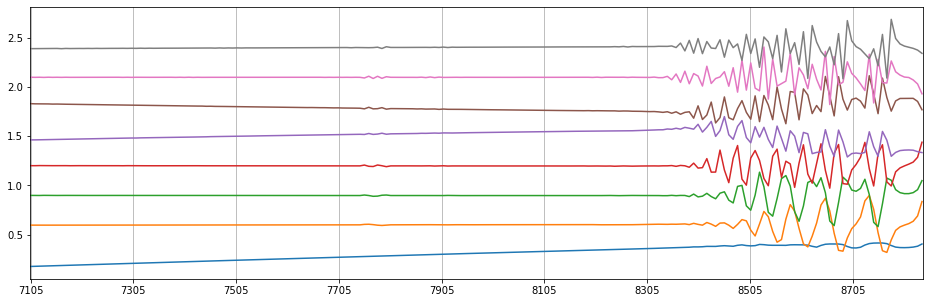

In [257]:
plot_V(waveL, v, top=8)

In [260]:
logfluxL[0].shape

(204,)

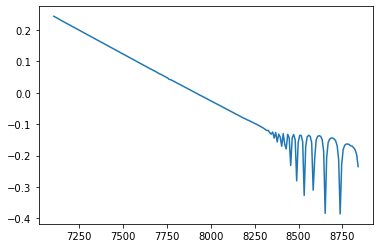

In [261]:
plt.plot(waveL, logfluxL[0])

In [258]:
errfluxL.shape

(204,)

In [249]:
logfluxL[0][0]

0.24424214900669117

In [245]:
errfluxL[0]

0.24424214900669117

In [262]:
error[0]

array([3.13339832e-18, 2.15706405e-18, 2.13680986e-18, ...,
       1.78463090e-18, 1.64066088e-18, 2.26884305e-18])

In [269]:
norm_flux.shape

(4800, 4096)

In [310]:
# er = norm_flux[idx] + np.random.normal(0, error[idx])
np.random.seed(42)
err = np.random.normal(0, error[idx])/flux[idx].mean()
errL = b.resampleFlux_i(err, step=20)
norm_errL = errL
# logerrL = np.log(errL)

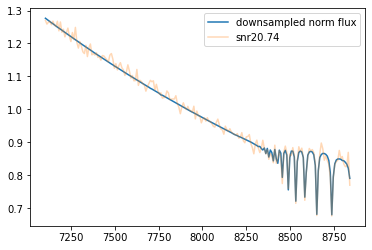

In [313]:
idx=0
plt.figure(facecolor="w")
plt.plot(waveL, fluxL[idx],label="downsampled norm flux")
plt.plot(waveL, fluxL[idx]+norm_errL,label=f"snr{snr[idx]:.2f}", alpha=0.3)
plt.legend()

In [316]:
np.log(fluxL[idx]+norm_errL)[:10]

array([0.23912826, 0.23029571, 0.23472111, 0.2371886 , 0.22868284,
       0.23719015, 0.22759242, 0.22421856, 0.23702135, 0.21376243])

In [318]:
logfluxL[idx]+norm_errL

array([ 0.23773015,  0.22729729,  0.23358027,  0.2373939 ,  0.22742899,
        0.23878701,  0.22739132,  0.22380175,  0.2406777 ,  0.21211698,
        0.23964162,  0.20917659,  0.21895819,  0.19653855,  0.21014664,
        0.22419049,  0.19968995,  0.18469275,  0.21250588,  0.1915657 ,
        0.22935669,  0.18370449,  0.1676014 ,  0.18785058,  0.17427239,
        0.15756118,  0.15298767,  0.17877101,  0.1448566 ,  0.1720562 ,
        0.18385223,  0.15143987,  0.15586899,  0.15167339,  0.15922833,
        0.14558458,  0.14765206,  0.13801746,  0.15237214,  0.15142812,
        0.14578575,  0.13979514,  0.13436221,  0.15559773,  0.16082913,
        0.14389404,  0.11681811,  0.13100286,  0.11237775,  0.12567035,
        0.13504135,  0.11977943,  0.11378477,  0.09716737,  0.10807547,
        0.12988876,  0.11176018,  0.09013517,  0.09828872,  0.08260074,
        0.08329619,  0.11733473,  0.06925512,  0.08508485,  0.08158517,
        0.07424003,  0.07067545,  0.05271944,  0.06620857,  0.07

In [322]:
a =logfluxL[idx]+norm_errL
a[:10]

array([0.23773015, 0.22729729, 0.23358027, 0.2373939 , 0.22742899,
       0.23878701, 0.22739132, 0.22380175, 0.2406777 , 0.21211698])

In [323]:
b = fluxL[idx]+norm_errL
b[:10]

array([1.27014143, 1.25897224, 1.26455604, 1.26768018, 1.25694333,
       1.26768214, 1.25557347, 1.25134448, 1.26746818, 1.23832842])

In [324]:
norm_errL[:20]

array([-0.006512  , -0.01426678, -0.00540948,  0.00097366, -0.00607675,
        0.00764893, -0.00098641, -0.00206832,  0.01779823, -0.00842972,
        0.02167176, -0.00597772,  0.00632307, -0.01340584,  0.00268633,
        0.01936949, -0.00250656, -0.01488876,  0.01553027, -0.00276846])

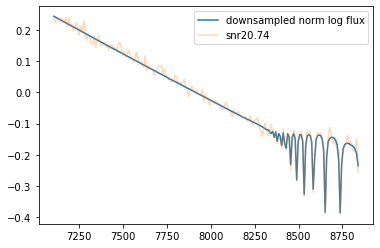

In [321]:
idx=0
plt.figure(facecolor="w")
plt.plot(waveL, logfluxL[idx],label="downsampled norm log flux")
plt.plot(waveL, logfluxL[idx]+norm_errL,label=f"snr{snr[idx]:.2f}", alpha=0.3)
plt.legend()

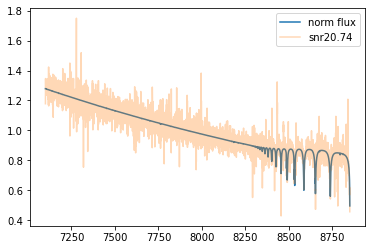

In [291]:
idx=0
plt.figure(facecolor="w")
plt.plot(wave, norm_flux[idx],label="norm flux")
plt.plot(wave, norm_flux[idx]+err,label=f"snr{snr[idx]:.2f}", alpha=0.3)
plt.legend()

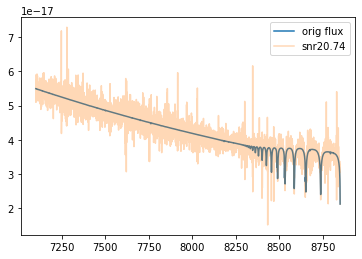

In [285]:
idx=0
plt.figure(facecolor="w")
plt.plot(wave, flux[idx],label="orig flux")
plt.plot(wave, flux[idx]+np.random.normal(0, error[idx]),label=f"snr{snr[idx]:.2f}", alpha=0.3)
plt.legend()

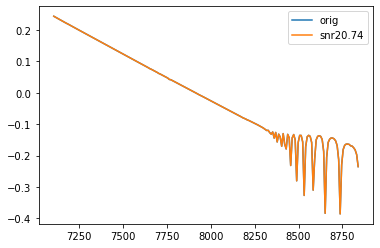

In [274]:
idx=0

plt.plot(waveL, logfluxL[idx],label="orig")
plt.plot(waveL, logerrL,label=f"snr{snr[idx]:.2f}")
plt.legend()

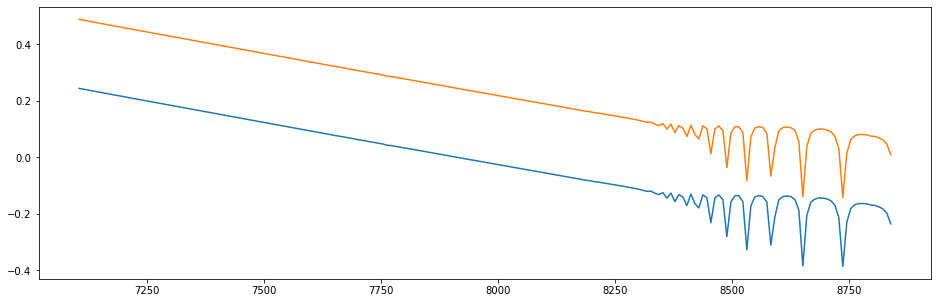

In [293]:
idx=0
plt.figure(figsize=(16,5))
# er = np.random.normal(0, error[idx])
err = np.random.normal(0, error[idx])/flux[0].mean()
errL = b.resampleFlux_i(er, step=20)
errfluxL = np.log(errL[idx])
plt.plot(waveL, logfluxL[idx],label="orig")
plt.plot(waveL, logfluxL[idx] + errfluxL,label=f"snr{snr[idx]}")

In [201]:
convert("B", N=10000)

#204 R=929.31
(10000, 4096) (10000, 204) (10000, 5)


./scripts/prepare.sh model bosz-rbf pfs --config ./configs/infer/pfs/bosz/nowave/prepare/train.json  ./configs/infer/pfs/bosz/nowave/inst_pfs_mr.json --chunk-size 1000 --sample-count 1000 --in /scratch/ceph/swei20/data/pfsspec/import/stellar/rbf/bosz_5000_BHB/rbf --out /scratch/ceph/swei20/data/pfsspec/train/pfs_stellar_model/dataset/BHB/bosz_5000_RedM_10k_t --Fe_H -2.5 -1.5 --T_eff 6750 9500 --log_g  2.0 3.5 --C_M -0.75 0.5 --O_M -0.25 0.5 --mag-filter /scratch/ceph/dobos/data/pfsspec/subaru/hsc/hsc_i.dat --mag 17 19 --thread 1